# **Introduction**

**This notebook dives into creating a machine learning model to diagnose glaucoma.**


***There has not been any solid dataset for glaucoma so I made one and created a model. Please check out my dataset if you are interested.***

![](https://www.reviewofoptometry.com/CMSImagesContent/2019/10/GlaucDiff1.jpg)

In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# **Organizing Data**

I took the data from the sources, and seperated them into train and validation folders. Then from those folders, I sorted them into positive and negative cases. You can check out my jupyter notebook linked at the end.

In [2]:
train_label = pd.read_csv('glaucoma.csv')
y_train = train_label['Glaucoma']
train_label.head()

Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0
3  004.jpg  0.7246  OD   A         0
4  005.jpg  0.6138  OS   A         0

# **Looking at the Data**

I first tried some manual data augmentation and preprocessing.

In [3]:
from numpy import asarray

from PIL import Image
# load the image
image = Image.open('glaucoma.jpeg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
pixels = asarray(image)

JPEG
RGB
(417, 389)


In [4]:

# global centering

# calculate global mean
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# global centering of pixels
pixels = pixels - mean
# confirm it had the desired effect
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)


# example of pixel normalization
# confirm pixel range is 0-255
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
mean = pixels.mean()
print('pixel mean = ', mean)

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)

Mean: 134.446
Min: 40.000, Max: 242.000
Mean: 0.000
Min: -94.446, Max: 107.554
[[[ 40.55393012 -27.44606988 -74.44606988]
  [ 41.55393012 -26.44606988 -73.44606988]
  [ 41.55393012 -26.44606988 -73.44606988]
  ...
  [ 54.55393012 -23.44606988 -71.44606988]
  [ 54.55393012 -23.44606988 -71.44606988]
  [ 57.55393012 -23.44606988 -70.44606988]]

 [[ 40.55393012 -27.44606988 -74.44606988]
  [ 40.55393012 -27.44606988 -74.44606988]
  [ 41.55393012 -26.44606988 -73.44606988]
  ...
  [ 54.55393012 -23.44606988 -71.44606988]
  [ 54.55393012 -23.44606988 -71.44606988]
  [ 56.55393012 -23.44606988 -72.44606988]]

 [[ 40.55393012 -27.44606988 -74.44606988]
  [ 41.55393012 -26.44606988 -73.44606988]
  [ 41.55393012 -26.44606988 -73.44606988]
  ...
  [ 54.55393012 -23.44606988 -71.44606988]
  [ 54.55393012 -23.44606988 -71.44606988]
  [ 56.55393012 -23.44606988 -72.44606988]]

 ...

 [[ 35.55393012 -46.44606988 -84.44606988]
  [ 35.55393012 -46.44606988 -84.44606988]
  [ 35.55393012 -46.44606988 -8

**Visulization**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


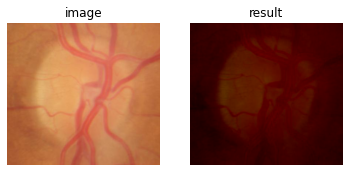

In [5]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax0.axis('off')
ax0.set_title('image')
ax1.imshow(pixels)
ax1.axis('off')
ax1.set_title('result')
plt.show()

In [12]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

# **Augmentation**

In [7]:
!pip install tensorflow

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input

# **Modeling**

In [7]:
TRAIN_DIR = r'C:\Users\tiash\Train'

TEST_DIR = r'C:\Users\tiash\Validation'

# **ConvNet**

In [39]:
'''import os
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator



model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))



train_generator = ImageDataGenerator(
  data_format="channels_last",
  rescale = 1. / 255
)

train_batches = train_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/train',
    target_size=(256, 256),
    class_mode='binary'
)

validation_generator = ImageDataGenerator(
  data_format="channels_last",
  rescale = 1. / 255
)

validation_batches = validation_generator.flow_from_directory(
    batch_size=32,
    directory='./dataset/validation',
    target_size=(256, 256),
    class_mode='binary'
)

model = create_model()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Starts training the model
model.fit_generator(train_batches,
                    epochs=15,
                    verbose=1,
                    steps_per_epoch=len(train_batches),
                    validation_data=validation_batches,
                    initial_epoch=0,
                    validation_steps=len(validation_batches)
                    )

test_generator = ImageDataGenerator(
    data_format='channels_last',
    rescale=1./255
)

test_batches = test_generator.flow_from_directory(
    batch_size=1,
    directory='./dataset/test',
    target_size=[256, 256],
    class_mode='binary'
)

score = model.evaluate_generator(test_batches, verbose=1)

print(model.metrics_names)
print('test dataset: ' + str(score))'''

'import os\nimport tensorflow as tf\nfrom keras.models import Sequential\nfrom keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten\nfrom keras.preprocessing.image import ImageDataGenerator\n\n\n\nmodel = Sequential()\nmodel.add(Conv2D(32, (3, 3), padding=\'same\', activation=\'relu\', input_shape=(256, 256, 3)))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\nmodel.add(Dropout(0.25))\n\nmodel.add(Flatten())\nmodel.add(Dense(128, activation=\'relu\'))\nmodel.add(Dropout(0.5))\nmodel.add(Dense(1, activation=\'softmax\'))\n\n\n\ntrain_generator = ImageDataGenerator(\n  data_format="channels_last",\n  rescale = 1. / 255\n)\n\ntrain_batches = train_generator.flow_from_directory(\n    batch_size=32,\n    directory=\'./dataset/train\',\n    target_size=(256, 256),\n    class_mode=\'binary\'\n)\n\nvalidation_generator = ImageDataGenerator(\n  data_format="channels_last",\n  rescale = 1. / 255\n)\n\nvalidation_batches = validation_generator.flow_from_directory(\n    batch_size=32,\n  

# **ResNet50**

In [8]:
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import TensorBoard
import keras
import matplotlib.pyplot as plt

HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 100
BATCH_SIZE = 8

def build_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    preditions = Dense(num_classes, activation='softmax')(x)
    finetune_model = Model(inputs = base_model.input, outputs = preditions)
    return finetune_model

base_model_1 = ResNet50(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)




resnet50_model = build_model(base_model_1,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

adam = Adam(lr = 0.00001)
resnet50_model.compile(adam, loss="binary_crossentropy", metrics=["accuracy"])

filepath = "./checkpoints" + "RestNet50" + "_model_weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max")
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

print(train_generator.class_indices)

resnet50_model.summary()

Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
1024
512
256
{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 306, 306, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 150, 150, 64  9472        ['conv1_pad[0][0]']              
                                )                

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv3_block1_3_conv (Conv2D)   (None, 38, 38, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 38, 38, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 38, 38, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 38, 38, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
          

In [9]:
history = resnet50_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100, 
                                       shuffle = True, validation_data = test_generator)

C:\Users\tiash\AppData\Local\Temp/ipykernel_7024/1517746525.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = resnet50_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100,


Epoch 1/100
100/100 [==============================] - 208s 2s/step - loss: 1.3555 - accuracy: 0.6577 - val_loss: 0.6205 - val_accuracy: 0.7154


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
[0. 1.]


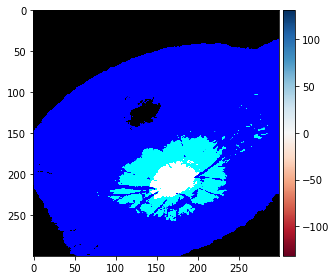

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


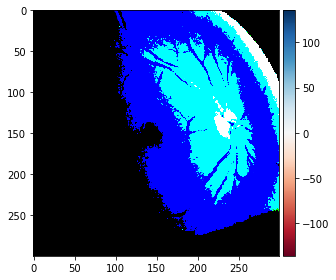

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1.]


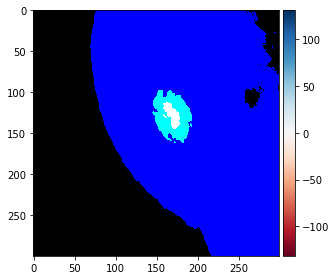

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


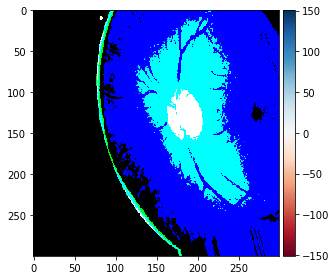

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


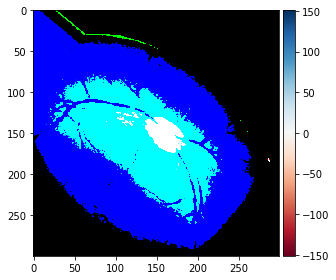

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


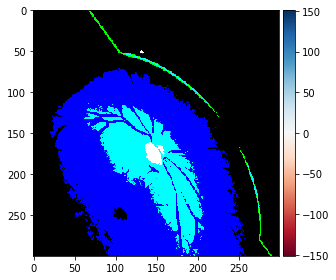

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


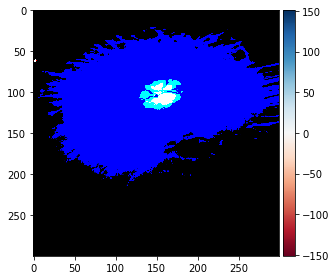

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


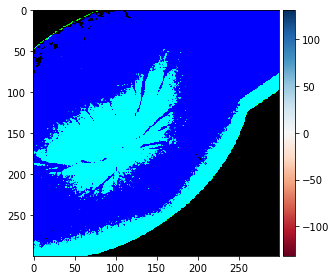

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
image_batch,label_batch = train_generator.next()

print(len(image_batch))
for i in range(0,len(image_batch)):
    image = image_batch[i]
    print(label_batch[i])
    imshow(image)

# **Inception V3**

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import RMSprop

In [15]:
base_model_2 = InceptionV3(weights = 'imagenet',
                       include_top = False,
                       input_shape = (HEIGHT, WIDTH, 3))

87910968/87910968 [==============================] - 18s 0us/step


In [16]:
inception_model = build_model(base_model_2,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))
inception_model.compile(optimizer = RMSprop(lr = 0.00001), loss="binary_crossentropy", metrics=["accuracy"])
inception_model.summary()

1024
512
256
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                              

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv2d_17 (Conv2D)             (None, 35, 35, 96)   82944       ['activation_16[0][0]']          
                                                                                                  
 conv2d_18 (Conv2D)             (None, 35, 35, 64)   16384       ['average_pooling2d_1[0][0]']    
                                                                                                  
 batch_normalization_12 (BatchN  (None, 35, 35, 64)  192         ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_14 (BatchN  (None, 35, 35, 64)  192         ['conv2d_14[0][0]']              
 ormalization)                                                                                    
          

In [17]:
history_2 = inception_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100, 
                                       shuffle = True, validation_data = test_generator)

C:\Users\tiash\AppData\Local\Temp/ipykernel_7024/895034147.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_2 = inception_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 100,


Epoch 1/100
100/100 [==============================] - 206s 2s/step - loss: 22.7711 - accuracy: 0.6423 - val_loss: 8.1985 - val_accuracy: 0.7385
